In [1408]:
import numpy as np
import sympy as sp
from scipy import optimize
import matplotlib.pyplot as plt

# Question 1

Consider the function f (x) = sin(x) − 0.5 over the interval [− π / 2 , π / 2 ].

a) What is the Taylor series expansion for f (x) around x = 0 ?

b) Graph f (x) over the interval [− π / 2 , π / 2 ].

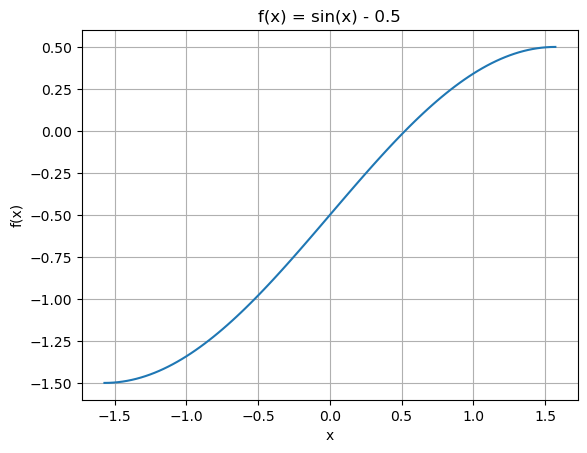

In [1409]:
# Graphs the function f(x) = sin(x) - 0.5 on the interval [-pi / 2, pi / 2]
x = np.linspace(-np.pi / 2, np.pi / 2, 100)
y = np.sin(x) - 0.5
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("f(x) = sin(x) - 0.5")
plt.grid()
plt.savefig("../figs/Q1.png")
plt.show()

c) Determine the best uniform approximation by a quadratic to the function f (x) on the interval [− π / 2 , π / 2 ].
What are the L∞ and L2 errors for this approximation?

In [1410]:
# define f(x) in sympy
x = sp.symbols("x", real=True)

f = sp.sin(x) - 0.5

In [1411]:
# define interval
a = -np.pi / 2
b = np.pi / 2

interval = [a, b]

In [1412]:
# define degree of polynomial
n = 2

In [1413]:
def find_all_roots(func, interval, num_points=100):
    x_vals = np.linspace(interval[0], interval[1], num_points)
    roots = []
    for i in range(len(x_vals) - 1):
        x0, x1 = x_vals[i], x_vals[i + 1]
        if np.sign(func(x0)) != np.sign(func(x1)):
            root = optimize.brentq(func, x0, x1)
            roots.append(root)
    return np.array(roots)

In [1414]:
def find_max(f, interval):
    """find the maximum value of a function f(x) on an interval [a, b]

    Args:
        f (_type_): function
        interval (list): the interval [a, b] to search for the maximum

    Returns:
        max_val (float): maximum value of f(x) on the interval
        max_x (float): x value where f(x) is maximized
    """
    x = sp.symbols("x", real=True)

    f_numerical = sp.lambdify(x, f, "numpy")

    f_prime = sp.diff(f, x)
    f_prime_numerical = sp.lambdify(x, f_prime, "numpy")

    roots = find_all_roots(f_prime_numerical, interval)
    roots = np.append(roots, interval)
    roots = np.unique(roots)

    max_val = np.max(f_numerical(roots))
    max_x = roots[np.argmax(f_numerical(roots))]

    return max_val, max_x

In [1415]:
def remez_exchange(
    f, n: int, interval: list, max_num_iteration: int = 100, tolerance: float = 1e-5
):
    """Remez Exchange Algorithm

    Args:
        f (_type_): univariate function
        n (int): polynomial degree
        interval (list): interval for uniform approximate
        max_num_iteration (int): max number of iteration
        tolerance (float): tolerance of point change between updates
    """

    assert len(interval) == 2, "Interval must be a list of 2 elements"

    # we need n + 2 points to construct a polynomial of degree n, uniform initialization
    xi = np.linspace(interval[0], interval[1], n + 2)

    # define x
    x = sp.symbols("x", real=True)

    # numerical function f
    f_numerical = sp.lambdify(x, f, "numpy")

    # determine if f^(n + 1) does not change sign in the interval
    f_n_plus_1 = sp.diff(f, x, n + 1)
    roots = find_all_roots(sp.lambdify(x, f_n_plus_1, "numpy"), interval)

    if len(roots) == 0:
        print("f^(n + 1) does not change sign in the interval")
        xi[0] = interval[0]
        xi[-1] = interval[1]

    # # some turbulence in the initial points
    # xi[1] = -1.0

    for iter in range(max_num_iteration):
        print(f"\nIteration {iter}\n")

        # construct linear system
        A = np.ones((n + 2, n + 2))
        for degree in range(n + 1):
            A[:, degree] = xi**degree
        A[:, -1] = (-1) ** np.arange(n + 2)

        b = f_numerical(xi).reshape(-1, 1)

        print(f"xi: {xi}")
        print(f"A: {A}")
        print(f"b: {b}")

        # solve linear system
        solution = np.linalg.solve(A, b).flatten()

        print(f"solution: {solution}")

        poly_coeff = solution[:-1]
        error = np.abs(solution[-1])

        # construct polynomial function with sympy
        poly = 0
        for degree in range(n + 1):
            poly += poly_coeff[degree] * x**degree

        print("Polynomial function:")
        sp.pprint(poly)

        # find the maximum error
        error_func = f - poly
        error_func_numerical = sp.lambdify(x, error_func, "numpy")
        max_error_abs, max_point = find_max(error_func, interval)
        print(f"max error: {max_error_abs}")
        print(f"max point: {max_point}")

        # filter out the points with the same sign as the maximum error
        xi_new = xi.copy()
        xi_same_sign = xi_new[
            np.where(
                np.sign(error_func_numerical(xi_new))
                == np.sign(error_func_numerical(max_point))
            )
        ]

        # find the closest point to the maximum error point and replace it with the maximum error point
        closest_point = xi_same_sign[np.argmin(np.abs(xi_same_sign - max_point))]
        xi_new[np.where(xi_new == closest_point)] = max_point

        print(f"xi_new: {xi_new}")

        # if the error changing is less than tolerance, break the loop
        if np.abs(np.abs(error) - max_error_abs) < tolerance:
            print(f"Converged after {iter} iterations")
            break

        xi = np.sort(xi_new)

    if iter == max_num_iteration - 1:
        print(f"Did not converge after {max_num_iteration} iterations")

    return poly, poly_coeff, max_error_abs

In [1416]:
poly, poly_coeff, E = remez_exchange(f, n, interval, max_num_iteration=1000)

f^(n + 1) does not change sign in the interval

Iteration 0

xi: [-1.57079633 -0.52359878  0.52359878  1.57079633]
A: [[ 1.         -1.57079633  2.4674011   1.        ]
 [ 1.         -0.52359878  0.27415568 -1.        ]
 [ 1.          0.52359878  0.27415568  1.        ]
 [ 1.          1.57079633  2.4674011  -1.        ]]
b: [[-1.50000000e+00]
 [-1.00000000e+00]
 [-1.66533454e-16]
 [ 5.00000000e-01]]
solution: [-5.00000000e-01  7.16197244e-01  2.10917083e-17  1.25000000e-01]
Polynomial function:
                      2                            
2.10917083053745e-17⋅x  + 0.716197243913529⋅x - 0.5
max error: 0.1446654676960616
max point: 0.7724582267976375
xi_new: [-1.57079633 -0.52359878  0.77245823  1.57079633]

Iteration 1

xi: [-1.57079633 -0.52359878  0.77245823  1.57079633]
A: [[ 1.         -1.57079633  2.4674011   1.        ]
 [ 1.         -0.52359878  0.27415568 -1.        ]
 [ 1.          0.77245823  0.59669171  1.        ]
 [ 1.          1.57079633  2.4674011  -1.        ]]
b:

In [1417]:
# Print the polynomial
print("Polynomial:")
sp.pprint(poly)

Polynomial:
                       2                                          
- 0.00454739176274951⋅x  + 0.720959261431812⋅x - 0.488779760561222


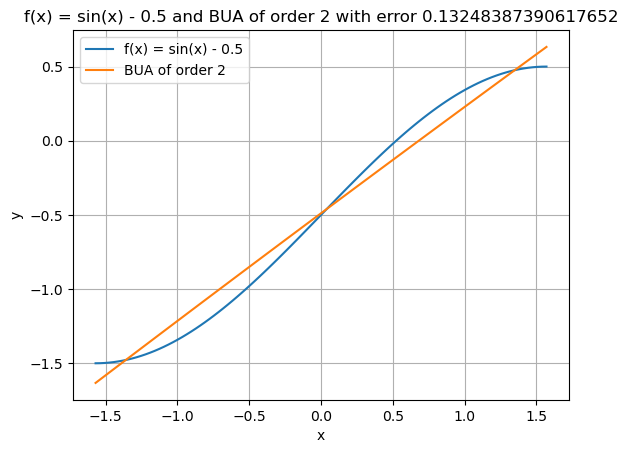

In [1418]:
# Graph the function f(x) = sin(x) - 0.5 and the polynomial approximation
x_point = np.linspace(interval[0], interval[1], 100)
y = np.sin(x_point) - 0.5
p = sp.lambdify(x, poly, "numpy")
y_poly = p(x_point)

plt.plot(x_point, y, label="f(x) = sin(x) - 0.5")
plt.plot(x_point, y_poly, label=f"BUA of order {n}")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"f(x) = sin(x) - 0.5 and BUA of order {n} with error {E}")
plt.legend()
plt.grid()
plt.savefig(f"../figs/Q1_c_poly_{n}.png")
plt.show()

In [1419]:
# Calculate L_2 error
sp.sqrt(sp.integrate((f - poly) ** 2, (x, interval[0], interval[1])))

0.173818650785871

d) Determine the best least-squares approximation by a quadratic to the function f (x) over the interval [− π / 2 , π / 2 ].
What are the L∞ and L2 errors for this approximation?

In [1420]:
def legendre_dot(f, g, interval: list):
    """The Legendre norm of the dot product of two functions

    Args:
        f (_type_): left function
        g (_type_): right function
        interval (list): interval of integration

    Returns:
        the norm
    """
    x = sp.symbols("x", real=True)
    return sp.integrate(f * g, (x, interval[0], interval[1]))

In [1421]:
def legendre_polynomial(n: int, interval: list):
    """Generate legendre polynomial of degree n

    Args:
        n (int): polynomial degree
        interval (list): the interval that defines the orthogonality

    Returns:
        the legendre polynomial
    """
    x = sp.symbols("x", real=True)
    if n > 1:
        P_n_minus_1 = legendre_polynomial(n - 1, interval)
        P_n_minus_2 = legendre_polynomial(n - 2, interval)
        return sp.expand(
            (
                x
                - legendre_dot(
                    x * P_n_minus_1,
                    P_n_minus_1,
                    interval,
                )
                / legendre_dot(
                    P_n_minus_1,
                    P_n_minus_1,
                    interval,
                )
            )
            * P_n_minus_1
            - legendre_dot(
                P_n_minus_1,
                P_n_minus_1,
                interval,
            )
            / legendre_dot(
                P_n_minus_2,
                P_n_minus_2,
                interval,
            )
            * P_n_minus_2
        )
    elif n == 1:
        return x
    elif n == 0:
        return 1
    else:
        raise ValueError("n must be a non-negative integer")

In [1422]:
interval = [-sp.pi / 2, sp.pi / 2]

In [1423]:
n = 2
print(f"Legendre polynomial of degree {n}")
sp.pprint(legendre_polynomial(n, interval))

Legendre polynomial of degree 2
      2
 2   π 
x  - ──
     12


In [1424]:
n = 3
print(f"Legendre polynomial of degree {n}")
sp.pprint(legendre_polynomial(n, interval))

Legendre polynomial of degree 3
        2  
 3   3⋅π ⋅x
x  - ──────
       20  


In [1425]:
n = 4
print(f"Legendre polynomial of degree {n}")
sp.pprint(legendre_polynomial(n, interval))

Legendre polynomial of degree 4
        2  2      4
 4   3⋅π ⋅x    3⋅π 
x  - ─────── + ────
       14      560 


In [1426]:
n = 5
print(f"Legendre polynomial of degree {n}")
sp.pprint(legendre_polynomial(n, interval))

Legendre polynomial of degree 5
        2  3      4  
 5   5⋅π ⋅x    5⋅π ⋅x
x  - ─────── + ──────
       18       336  


In [1427]:
n = 6
print(f"Legendre polynomial of degree {n}")
sp.pprint(legendre_polynomial(n, interval))

Legendre polynomial of degree 6
         2  4      4  2      6 
 6   15⋅π ⋅x    5⋅π ⋅x    5⋅π  
x  - ──────── + ─────── - ─────
        44        176     14784


In [1428]:
def least_square_approximation(f, n: int, interval: list):
    """Least square approximation

    Args:
        f (_type_): univariate function
        n (int): polynomial degree
        interval (list): interval for uniform approximate

    Returns:
        the polynomial
    """

    x = sp.symbols("x", real=True)

    # construct the legendre polynomials
    legendre_polynomials = [legendre_polynomial(i, interval) for i in range(n + 1)]

    print(f"Legendre polynomials: {legendre_polynomials}")

    projection_coefficients = [
        legendre_dot(f, P, interval) / legendre_dot(P, P, interval)
        for P in legendre_polynomials
    ]

    print(f"Projection coefficients: {projection_coefficients}")

    poly = 0
    for coefficient, P in zip(projection_coefficients, legendre_polynomials):
        poly += coefficient * P

    return poly

In [1429]:
n = 2
poly = least_square_approximation(f, n, interval)
print(f"Degree {n} least square approximation of function {f}")
sp.pprint(poly)

Legendre polynomials: [1, x, x**2 - pi**2/12]
Projection coefficients: [-0.500000000000000, 24.0/pi**3, 0]
Degree 2 least square approximation of function sin(x) - 0.5
24.0⋅x      
────── - 0.5
   3        
  π         


In [1430]:
interval_numerical = [float(interval[0]), float(interval[1])]

In [1431]:
L_inf, _ = find_max(f - poly, interval_numerical)
print(f"Maximum error: {L_inf}")

Maximum error: 0.2158542037080533


In [1432]:
L_2 = sp.sqrt(sp.integrate((f - poly) ** 2, (x, -np.pi / 2, np.pi / 2)))
print(f"L_2 error: {float(sp.Abs(L_2))}")

L_2 error: 0.15074041926875908


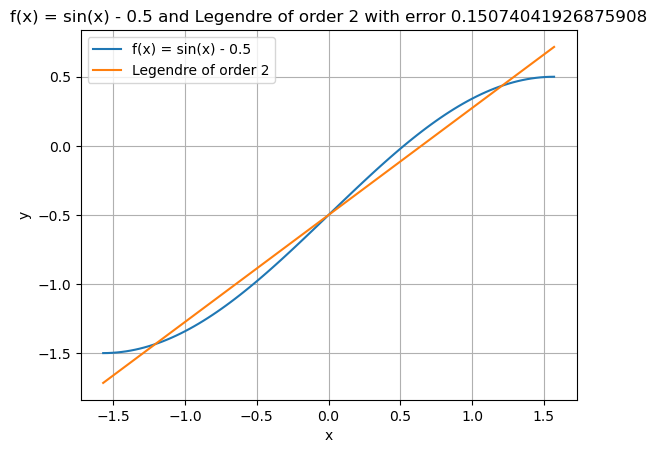

In [1433]:
# Graph the function f(x) = sin(x) - 0.5 and the polynomial approximation
x_point = np.linspace(interval_numerical[0], interval_numerical[1], 100)
y = np.sin(x_point) - 0.5
p = sp.lambdify(x, poly, "numpy")
y_poly = p(x_point)

plt.plot(x_point, y, label="f(x) = sin(x) - 0.5")
plt.plot(x_point, y_poly, label=f"Legendre of order {n}")
plt.xlabel("x")
plt.ylabel("y")
plt.title(
    f"f(x) = sin(x) - 0.5 and Legendre of order {n} with error {float(sp.Abs(L_2))}"
)
plt.legend()
plt.grid()
plt.savefig(f"../figs/Q1_d_poly_{n}.png")
plt.show()

Terminology: Suppose an approximation has error function e(x), with x in interval [a, b]. The L∞ error is ||e(x)||∞ =max a≤x≤b |e(x)| and the L2 error is ||e(x)||2 = √∫ b a |e(x)|2dx.

For your code submission, submit any code you used.

In your pdf, please show all your hand derivations and code results, and replicate any code you would like the TAs to see.